In [ ]:
!python3 -c "import lightning" || pip install lightning==2.2.4
!python3 -c "import torchsummary" || pip install torchsummary

In [1]:
from collections import OrderedDict
from torchvision import models
from torch import nn
from torch.utils.data import Dataset
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
import lightning as L
import torch
import os
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from skimage import data, io
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    pairwise_distances,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    cohen_kappa_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    classification_report,
)
import seaborn as sns
import random
from torchvision.transforms import v2
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as TVF
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from lightning.pytorch.loggers import CSVLogger

In [2]:
print(torch.cuda.get_arch_list())

['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_37', 'sm_90']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_05_08_objects_clear/pollen_dataset_2024_05_08_objects"

In [6]:
random.seed(42)

In [7]:
def pad2size(image, size=(224, 224)):
    return ImageOps.fit(image, size)

class PollenTripletDataset(Dataset):
    def __init__(self, img_dir, classes, 
                 static_transform=None, 
                 random_transform=None,
                 inflation_rate=1):
        self.known_classes = classes
        self.known_classes_numbers = list(range(len(classes)))
        self.known_classes.sort()
        self.transform = random_transform
        self._all_samples = []
        self._indices_to_class = {}
        self._class_to_indices = {i: [] for i,c in enumerate(self.known_classes)}
        total_samples = 0
        
        for c in tqdm(self.known_classes):
            c_number = len(self._indices_to_class)
            self._indices_to_class[c_number] = c
            images = glob(os.path.join(img_dir, c, "*.png"))
            print(f"{len(images)} samples in the class {c}")
            
            for idx, img_path in enumerate(tqdm(images)):
                img = Image.open(img_path)
                if static_transform is not None:
                    img = static_transform(img)
                self._all_samples.append((c_number, img))
                self._class_to_indices[c_number].append(total_samples)
                total_samples += 1
        
        print(f"Total samples: {total_samples}")

    def __len__(self):
        return len(self._all_samples)

    def __getitem__(self, idx):
        label, anchor = self._all_samples[idx]
        label_str = self._indices_to_class[label]
        
        positive_idx = random.choice(self._class_to_indices[label])
        positive = self._all_samples[positive_idx][1]
        
        neg_classes = [c for c in self.known_classes_numbers if c != label]
        negative_class = random.choice(neg_classes)
        negative_idx = random.choice(self._class_to_indices[negative_class])
        negative_label, negative = self._all_samples[negative_idx]
        negative_str = self._indices_to_class[negative_label]
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        anchor = torch.as_tensor(anchor) if not isinstance(anchor, torch.Tensor) else anchor
        positive = torch.as_tensor(positive) if not isinstance(positive, torch.Tensor) else positive
        negative = torch.as_tensor(negative) if not isinstance(negative, torch.Tensor) else negative

        return anchor, positive, negative, label, label_str, negative_label, negative_str

known_classes = os.listdir(OBJECTS_ROOT)

print(f"All known classes: {known_classes}")
train_classes, test_classes = train_test_split(known_classes, test_size=0.2, random_state=42)
train_classes, val_classes = train_test_split(train_classes, test_size=0.2, random_state=42)

print(f"Train classes: {train_classes}")
print(f"Validation classes: {val_classes}")
print(f"Test classes: {test_classes}")

input_size=(224, 224)

static_transforms = v2.Compose([
    v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("\nLoad Train Dataset")
dataset_train = PollenTripletDataset(OBJECTS_ROOT, train_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Validation Dataset")
dataset_val = PollenTripletDataset(OBJECTS_ROOT, val_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Test Dataset")
dataset_test = PollenTripletDataset(OBJECTS_ROOT, test_classes, static_transform=static_transforms, inflation_rate=100)

All known classes: ['Alnus', 'Betula', 'Corylus', 'Acer', 'Pinus', 'Salix', 'Populus tremula', 'Tilia', 'Quercus']
Train classes: ['Acer', 'Quercus', 'Pinus', 'Corylus', 'Populus tremula']
Validation classes: ['Salix', 'Alnus']
Test classes: ['Tilia', 'Betula']

Load Train Dataset


  0%|          | 0/5 [00:00<?, ?it/s]

319 samples in the class Acer


  0%|          | 0/319 [00:00<?, ?it/s]

141 samples in the class Corylus


  0%|          | 0/141 [00:00<?, ?it/s]

67 samples in the class Pinus


  0%|          | 0/67 [00:00<?, ?it/s]

201 samples in the class Populus tremula


  0%|          | 0/201 [00:00<?, ?it/s]

90 samples in the class Quercus


  0%|          | 0/90 [00:00<?, ?it/s]

Total samples: 818

Load Validation Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

25 samples in the class Alnus


  0%|          | 0/25 [00:00<?, ?it/s]

227 samples in the class Salix


  0%|          | 0/227 [00:00<?, ?it/s]

Total samples: 252

Load Test Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

206 samples in the class Betula


  0%|          | 0/206 [00:00<?, ?it/s]

114 samples in the class Tilia


  0%|          | 0/114 [00:00<?, ?it/s]

Total samples: 320


In [8]:
def plot(imgs, row_title=None, labels=None, **imshow_kwargs):
    if labels != None:
        ax_title = True
    else:
        ax_title = False
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            # print(img.unique())
            img = TVF.to_dtype(img, torch.uint8, scale=True)
            black_pixels = (img != 0).all(dim=0)
            img[:, ~black_pixels] = 255
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if ax_title:
                ax.set_title(labels[col_idx])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [9]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 48,
    shuffle= True,
    num_workers= 6
)
val_loader = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 4,
    shuffle= True,
    num_workers= 6
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size= 1,
    shuffle= True,
    num_workers= 6
)

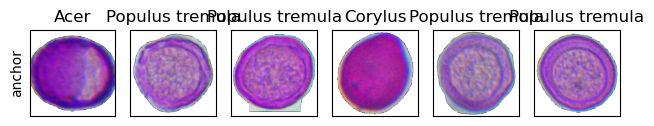

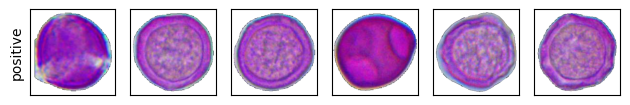

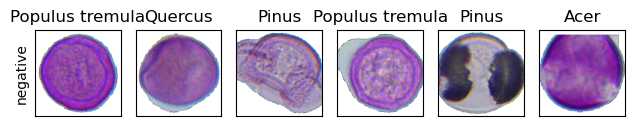

In [10]:
for anchor, positive, negative, label, label_str, negative_label, negative_str in train_loader:
    plot(anchor[:6], row_title=["anchor"], labels=label_str[:6])
    plot(positive[:6], row_title=["positive"])
    plot(negative[:6], row_title=["negative"], labels=negative_str[:6])
    break

In [51]:
class EmbeddingModel(nn.Module):
    def __init__(self, embeddings=128):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.embeddings = nn.Linear(2048, embeddings)
        self.model.fc = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.embeddings(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x

class PollenEmbeddingsModule(L.LightningModule):
    def __init__(self,
                 optim_lr=0.001,
                 optim_betas=(0.9, 0.999),
                 optim_eps=1e-08,
                 optim_weight_decay=0,
                 check_val=20
                 ):
        super().__init__()
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters()

        self.loss_function = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

        self.best_score = 1
        self.best_val_epoch = -1

        self.model = EmbeddingModel()

        self.train_step_outputs = []
        self.val_step_outputs = []
        self.train_losses = []
        self.val_losses = []

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        anchor, positive, negative, _, _, _, _ = batch

        anchor_out = self.model(anchor)
        positive_out = self.model(positive)
        negative_out = self.model(negative)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)
        pred = {"train_loss": loss, "train_number": len(anchor_out)}
        self.train_step_outputs.append(pred)
        return loss

    def on_train_epoch_end(self):
        outputs = self.train_step_outputs
        train_loss, num_items = 0, 0
        for output in outputs:
            train_loss += output["train_loss"].sum().item()
            num_items += output["train_number"]

        mean_train_loss = torch.tensor(train_loss / num_items)
        self.log("train_loss", mean_train_loss)
        self.train_losses.append(mean_train_loss.item())
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        anchor, positive, negative, _, _, _, _ = batch
        anchor_out = self.model(anchor)
        positive_out = self.model(positive)
        negative_out = self.model(negative)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)
        pred = {"val_loss": loss, "val_number": len(anchor_out)}
        self.val_step_outputs.append(pred)

    def on_validation_epoch_end(self):
        outputs = self.val_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)
        self.val_losses.append(mean_val_loss.item())
        self.val_step_outputs.clear()  # free memory
        
        tensorboard_logs = {
            "val_loss": mean_val_loss
        }
        self.log("val_loss", mean_val_loss)

        if mean_val_loss < self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot([i for i in range(len(self.train_losses))], self.train_losses, label='Train Loss')
        plt.plot([i * self.hparams.check_val for i in range(len(self.val_losses))], self.val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

In [52]:
model = PollenEmbeddingsModule(check_val=5)

In [53]:
model = model.to(device)
summary(model.model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [54]:
checkpoint_callback = ModelCheckpoint(
    filename='checkpoint-{epoch:02d}-{val_loss:.2f}',
    # auto_insert_metric_name=False,
    dirpath="./history",
    monitor='val_loss',
    mode='min')
lr_logger = LearningRateMonitor()
logger = CSVLogger("logs", name="triplet_1")

In [55]:
trainer = L.Trainer(logger=logger,
                    log_every_n_steps=1,  # Increase, if epoch size is large
                    callbacks=[checkpoint_callback, lr_logger],
                    precision="16-mixed",
                    check_val_every_n_epoch=model.hparams.check_val,
                    max_epochs=15,
                    accumulate_grad_batches=2,
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [56]:
trainer.fit(model, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader,     
)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/jovyan/git/Pollen-Analyzer/Classification/history exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | loss_function | TripletMarginLoss | 0     
1 | model         | EmbeddingModel    | 23.8 M
----------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.081    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


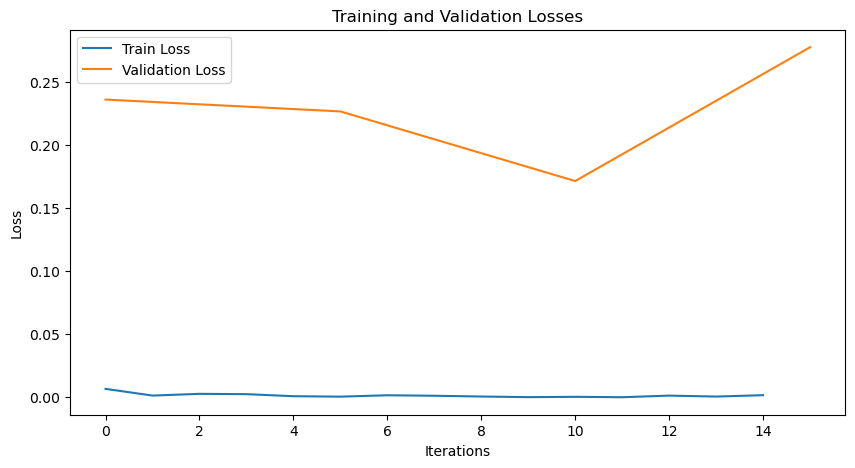

In [57]:
model.plot_losses()

## Loading the model

In [58]:
checkpoint_path = "/home/jovyan/git/Pollen-Analyzer/Classification/history/checkpoint-epoch=09-val_loss=0.17.ckpt"
model = PollenEmbeddingsModule.load_from_checkpoint(checkpoint_path)

In [59]:
model.eval()
model = model.cuda()

## Metrics and quality analysis

In [60]:
def add_class_markings(ax, class_boundaries, labels):
    tick_locs = [(class_boundaries[i] + class_boundaries[i+1] - 1) / 2 for i in range(len(class_boundaries)-1)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    ax.set_xticklabels([labels[int(loc)] for loc in tick_locs])
    ax.set_yticklabels([labels[int(loc)] for loc in tick_locs])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for boundary in class_boundaries[1:-1]:
        ax.axhline(y=boundary-1, color='k', linestyle='-', linewidth=1)
        ax.axvline(x=boundary-1, color='k', linestyle='-', linewidth=1)

In [61]:
def plot_matrix(embeddings_lists: list, labels_lists: list, subtitle: str=None, axes_class_markings: bool=True):
    all_labels_sorted, all_embeddings_sorted, class_boundaries = prepare_data(embeddings_lists, labels_lists)

    pairwise_dist = pairwise_distances(all_embeddings_sorted)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(pairwise_dist, cmap='Blues_r')
    plt.colorbar(im)

    if axes_class_markings:
        add_class_markings(ax, class_boundaries, all_labels_sorted)

    if subtitle != None:
        plt.title('Pairwise Distance Matrix\n' + subtitle)
    else:
        plt.title('Pairwise Distance Matrix')
    plt.tight_layout()
    plt.show()
    del all_labels_sorted
    del all_embeddings_sorted
    del class_boundaries

In [62]:
def prepare_data(embeddings_lists: list, labels_lists: list):
    all_labels_sorted = []
    all_embeddings_sorted = []
    class_boundaries = [0]
    for i, embeddings_list in enumerate(embeddings_lists):
        labels_list = labels_lists[i]
        class_to_idx = {}
        for i, class_name in enumerate(np.unique(labels_list)):
            class_to_idx[class_name] = i
        all_labels_idx = [class_to_idx[label] for label in labels_list]
        sorted_indices = sorted(range(len(embeddings_list)), key=lambda i: all_labels_idx[i])
        start = len(all_labels_sorted) + 1
        all_embeddings_sorted.extend([embeddings_list[i] for i in sorted_indices])
        all_labels_sorted.extend([labels_list[i] for i in sorted_indices])
    
        for i in range(start, len(all_labels_sorted)):
            if all_labels_sorted[i] != all_labels_sorted[i-1]:
                class_boundaries.append(i)
        class_boundaries.append(len(all_labels_sorted))

    return all_labels_sorted, all_embeddings_sorted, class_boundaries

In [63]:
def process_loader(model, loader):
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            imgs, _, _, _, labels_str, _, _ = batch
            imgs = imgs.cuda()
            embeddings = model(imgs)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels_str)
        all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()
    return all_embeddings, all_labels

In [64]:
loaders_list = [test_loader, val_loader, train_loader]
embeddings_data = []
labels_data_str = []

In [65]:
for loader in tqdm(loaders_list):
    embeddings, labels = process_loader(model, loader)
    embeddings_data.append(embeddings)
    labels_data_str.append(labels)

  0%|          | 0/3 [00:00<?, ?it/s]

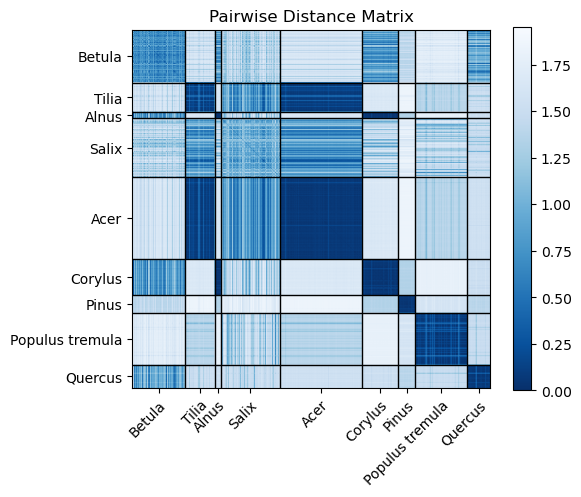

In [66]:
plot_matrix(embeddings_data, labels_data_str)